In [2]:
import os
import ogr
import gdal
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Create path to data directory, make sure it exists
data_dir = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir),"Data")
assert os.path.isdir

In [10]:
# Define paths to shapefile and shape files + make sure it exists
trdf = os.path.join(data_dir, "Training_Data.shp")
assert os.path.isfile(trdf)

valf = os.path.join(data_dir, "Validation_Data.shp")
assert os.path.isfile(valf)

imgf = os.path.join(data_dir, "CASI_Subset.tif")
assert os.path.isfile(imgf)

In [57]:
class_mappings = {1:"Dead Grass", 2:"River", 3:"Pool", 4:"Grass", 5:"Tree", 6:"Road" }

In [21]:
# Lets write a function that gives us the row/column offset and the number of rows and columns to extract
# This function will help us extract the box of pixels around the feature in question. the geotransform 
# comes from the raster, the bounding box comes from a specific feature in a shapfile

def bbox_to_pixel_offsets(geo_transform, bounding_box):
    origin_x = geo_transform[0]
    origin_y = geo_transform[3]
    pixel_width = geo_transform[1]
    pixel_height = geo_transform[5]
    x1 = int(round((bounding_box[0] - origin_x) / pixel_width))
    x2 = int(round((bounding_box[1] - origin_x) / pixel_width))
    y1 = int(round((bounding_box[3] - origin_y) / pixel_height))
    y2 = int(round((bounding_box[2] - origin_y) / pixel_height))
    xsize = x2 - x1
    ysize = y2 - y1
    return [x1, y1, xsize, ysize]
    

In [26]:
def extract_data(vector_path, raster_path, fid, class_field_name=None):
    
    # Turn raster data into a numpy array
    rds = gdal.Open(raster_path)
    gt = rds.GetGeoTransform()
    
    # Open the vector dataset and get the data layer
    vds = ogr.Open(vector_path)
    lyr = vds.GetLayer(0)
    
    #get the feature provided from the function arguements
    feature = lyr.GetFeature(fid)
    bbox = feature.geometry().GetEnvelope()
    
    offset = bbox_to_pixel_offsets(gt, bbox)
    
    # Two ways of doing this ...
    # 1. use arguements of ReadAsArray to only read the part of the raster we want
    option1 = rds.ReadAsArray(xoff=offset[0], yoff=offset[1], xsize=offset[2], ysize=offset[3])
    
    #2. Read the array into memory and then index the array
    # Why would we want to do one over the other          <--------------------------QUESTION
    # Preforming "ReadAsArray" on the dataset assumes that you want all of the bands
    # returned to you in a (bands, rows, columns) shaped array
    data = rds.ReadAsArray()
    option2 = data[:,offset[1]:offset[1]+offset[3],offset[0]:offset[0]+offset[2]]
    
    return option1, option2
    
    
    
    

In [48]:
rds.RasterCount

5

In [27]:
# Run the function
a, b = extract_data(trdf, imgf, 0)

In [33]:
# Show that both are equal
a.all() == b.all()

True

In [30]:
# Resume working on function -- copy from above
def extract_data(vector_path, raster_path, fid, class_field_name=None):
    
    # Turn raster data into a numpy array
    rds = gdal.Open(raster_path)
    gt = rds.GetGeoTransform()
    
    # Open the vector dataset and get the data layer
    vds = ogr.Open(vector_path)
    lyr = vds.GetLayer(0)
    
    #get the feature provided from the function arguements
    feature = lyr.GetFeature(fid)
    bbox = feature.geometry().GetEnvelope()
    
    offset = bbox_to_pixel_offsets(gt, bbox)
    
    # use arguements of ReadAsArray to only read the part of the raster we want
    subset = rds.ReadAsArray(xoff=offset[0], yoff=offset[1], xsize=offset[2], ysize=offset[3])
    
    return subset

(5, 13, 12)

In [ ]:
# Show that this doesn't return exactly what we want...
plt.imshow(data_from_above)  # Compare with arcmap

In [34]:
# lets work on the function to mask the subset with the shape of the vector -- copy function
def extract_data(vector_path, raster_path, fid, class_field_name=None):
    
    # Turn raster data into a numpy array
    rds = gdal.Open(raster_path)
    gt = rds.GetGeoTransform()
    
    # Open the vector dataset and get the data layer
    vds = ogr.Open(vector_path)
    lyr = vds.GetLayer(0)
    
    #get the feature provided from the function arguements
    feature = lyr.GetFeature(fid)
    bbox = feature.geometry().GetEnvelope()
    
    offset = bbox_to_pixel_offsets(gt, bbox)
    
    # use arguements of ReadAsArray to only read the part of the raster we want
    subset = rds.ReadAsArray(xoff=offset[0], yoff=offset[1], xsize=offset[2], ysize=offset[3])
    
    mem_drv = ogr.GetDriverByName('Memory')
    driver = gdal.GetDriverByName('MEM')

    new_gt = ((gt[0] + (offset[0] * gt[1])), gt[1], 0.0,
              (gt[3] + (offset[1] * gt[5])), 0.0, gt[5])
    
    mem_ds = mem_drv.CreateDataSource('out')
    mem_layer = mem_ds.CreateLayer('poly', lyr.GetSpatialRef(), ogr.wkbPolygon)

    mem_layer.CreateFeature(feature.Clone())
    rvds = driver.Create('', offset[2], offset[3], 1, gdal.GDT_Byte)
    rvds.SetGeoTransform(new_gt)

    gdal.RasterizeLayer(rvds, [1], mem_layer, burn_values=[1])
    rv_array = rvds.ReadAsArray()
    
    return subset, rv_array

sub, mask = extract_data(trdf, imgf, 0)

In [45]:
# We should add something that gives us information about what we just extracted
# Added block at the bottom about class labels

def extract_data(vector_path, raster_path, fid, class_field_name=None):
    
    # Turn raster data into a numpy array
    rds = gdal.Open(raster_path)
    gt = rds.GetGeoTransform()
    
    # Open the vector dataset and get the data layer
    vds = ogr.Open(vector_path)
    lyr = vds.GetLayer(0)
    
    #get the feature provided from the function arguements
    feature = lyr.GetFeature(fid)
    bbox = feature.geometry().GetEnvelope()
    
    offset = bbox_to_pixel_offsets(gt, bbox)
    
    # use arguements of ReadAsArray to only read the part of the raster we want
    subset = rds.ReadAsArray(xoff=offset[0], yoff=offset[1], xsize=offset[2], ysize=offset[3])
    
    # Section of code to rasterize a feature -- shoutout GB 
    mem_drv = ogr.GetDriverByName('Memory')
    driver = gdal.GetDriverByName('MEM')

    new_gt = ((gt[0] + (offset[0] * gt[1])), gt[1], 0.0,
              (gt[3] + (offset[1] * gt[5])), 0.0, gt[5])
    
    mem_ds = mem_drv.CreateDataSource('out')
    mem_layer = mem_ds.CreateLayer('poly', lyr.GetSpatialRef(), ogr.wkbPolygon)

    mem_layer.CreateFeature(feature.Clone())
    rvds = driver.Create('', offset[2], offset[3], 1, gdal.GDT_Byte)
    rvds.SetGeoTransform(new_gt)

    gdal.RasterizeLayer(rvds, [1], mem_layer, burn_values=[1])
    rv_array = rvds.ReadAsArray()
    
    # Get the class label for this feature
    if not class_field_name is None:
        cls = feature.GetField(class_field_name)
        pixel_labels = cls * rv_array
    else:
        pixel_labels=None
    
    return subset, rv_array, pixel_labels

sub, mask, labels  = extract_data(trdf, imgf, 0, class_field_name="Class")
print(sub.shape)
print(mask.shape)
print(labels.shape)

In [46]:
labels

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 5, 5, 5, 5, 5, 0, 0, 0, 0],
       [0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0],
       [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0],
       [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0],
       [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0],
       [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0],
       [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0],
       [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0],
       [0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [49]:
# Is this the most useful form for our data?
# Lets change its shape  
# Add bands = rds.RasterCount
# Add .reshape() method for subset line and rv_array line

def extract_data(vector_path, raster_path, fid, class_field_name=None):
    
    # Turn raster data into a numpy array
    rds = gdal.Open(raster_path)
    gt = rds.GetGeoTransform()
    bands = rds.RasterCount
    
    # Open the vector dataset and get the data layer
    vds = ogr.Open(vector_path)
    lyr = vds.GetLayer(0)
    
    #get the feature provided from the function arguements
    feature = lyr.GetFeature(fid)
    bbox = feature.geometry().GetEnvelope()
    
    offset = bbox_to_pixel_offsets(gt, bbox)
    
    # use arguements of ReadAsArray to only read the part of the raster we want
    subset = rds.ReadAsArray(xoff=offset[0], yoff=offset[1], xsize=offset[2], ysize=offset[3]).reshape(bands, -1).T
    
    # Section of code to rasterize a feature -- shoutout GB 
    mem_drv = ogr.GetDriverByName('Memory')
    driver = gdal.GetDriverByName('MEM')

    new_gt = ((gt[0] + (offset[0] * gt[1])), gt[1], 0.0,
              (gt[3] + (offset[1] * gt[5])), 0.0, gt[5])
    
    mem_ds = mem_drv.CreateDataSource('out')
    mem_layer = mem_ds.CreateLayer('poly', lyr.GetSpatialRef(), ogr.wkbPolygon)

    mem_layer.CreateFeature(feature.Clone())
    rvds = driver.Create('', offset[2], offset[3], 1, gdal.GDT_Byte)
    rvds.SetGeoTransform(new_gt)

    gdal.RasterizeLayer(rvds, [1], mem_layer, burn_values=[1])
    rv_array = rvds.ReadAsArray().reshape(-1,1)
    
    # Get the class label for this feature
    if not class_field_name is None:
        cls = feature.GetField(class_field_name)
        pixel_labels = cls * rv_array
    else:
        pixel_labels=None
    
    return subset, rv_array, pixel_labels

sub, mask, labels  = extract_data(trdf, imgf, 0, class_field_name="Class")
print(sub.shape)
print(mask.shape)
print(labels.shape)

(156, 5)
(156, 1)
(156, 1)


In [51]:
# Lets add a loop to go through the whole file
# add feature_count line
# add for loop
# remove optional argument for class_field_name, and adjust code block accordingly
# add lists to collect data


def extract_data(vector_path, raster_path, fid, class_field_name):
    
    # Turn raster data into a numpy array
    rds = gdal.Open(raster_path)
    gt = rds.GetGeoTransform()
    bands = rds.RasterCount
    
    # Open the vector dataset and get the data layer
    vds = ogr.Open(vector_path)
    lyr = vds.GetLayer(0)
    feature_count = lyr.GetFeatureCount()
    
    image_list = []
    mask_list = []
    fid_list = []
    labels_list = []
    
    for fid in range(feature_count):
        #get the feature provided from the function arguements
        feature = lyr.GetFeature(fid)
        bbox = feature.geometry().GetEnvelope()

        offset = bbox_to_pixel_offsets(gt, bbox)

        # use arguements of ReadAsArray to only read the part of the raster we want
        subset = rds.ReadAsArray(xoff=offset[0], yoff=offset[1], xsize=offset[2], ysize=offset[3]).reshape(bands, -1).T

        # Section of code to rasterize a feature -- shoutout GB 
        mem_drv = ogr.GetDriverByName('Memory')
        driver = gdal.GetDriverByName('MEM')

        new_gt = ((gt[0] + (offset[0] * gt[1])), gt[1], 0.0,
                  (gt[3] + (offset[1] * gt[5])), 0.0, gt[5])

        mem_ds = mem_drv.CreateDataSource('out')
        mem_layer = mem_ds.CreateLayer('poly', lyr.GetSpatialRef(), ogr.wkbPolygon)

        mem_layer.CreateFeature(feature.Clone())
        rvds = driver.Create('', offset[2], offset[3], 1, gdal.GDT_Byte)
        rvds.SetGeoTransform(new_gt)

        gdal.RasterizeLayer(rvds, [1], mem_layer, burn_values=[1])
        rv_array = rvds.ReadAsArray().reshape(-1,1)

        # Get the class label for this feature
        cls = feature.GetField(class_field_name)
        pixel_labels = cls * rv_array
        
        # Make array for FIDs
        fids = fid * rv_array
        
        # Add each iteration to the master list
        image_list += [list(px) for px in subset]
        mask_list += [px for px in rv_array]
        fid_list += [px for px in fids]
        labels_list += [px for px in pixel_labels]
          

    return np.array(image_list).T, np.array(mask_list).T, np.array(fid_list).T, np.array(labels_list)

image_data, mask_data, fid_data, label_data  = extract_data(trdf, imgf, 0, class_field_name="Class")
print(image_data.shape)
print(mask_data.shape)
print(fid_data.shape)
print(label_data.shape)    

(3605, 5)
(3605, 1)
(3605, 1)
(3605, 1)


In [52]:
# show we have data for pixels that are not inside our features
np.sum(mask_data)

2363

(433, 5)

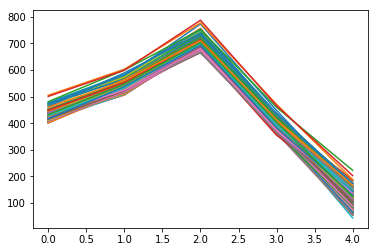

In [56]:
# lets plot something
# plot all pixels with class label of 2 ()
plt.plot(image_data[label_data[:,0]==2].T)
plt.show()

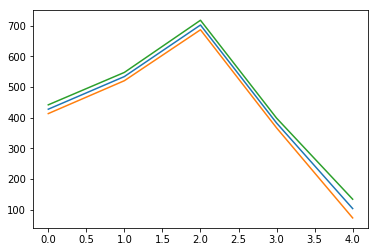

In [73]:
# Take average of a spectra:
valid_px = image_data[mask_data[:,0]==1]
valid_labels = label_data[mask_data[:,0]==1]
                          
                          
grass_mean = np.mean(valid_px[valid_labels[:,0]==2], axis=0)
grass_std = np.std(valid_px[valid_labels[:,0]==2], axis=0)
grass_min = grass_mean - grass_std
grass_max = grass_mean + grass_std
plt.plot(grass_mean.T)
plt.plot(grass_min.T)
plt.plot(grass_max.T)

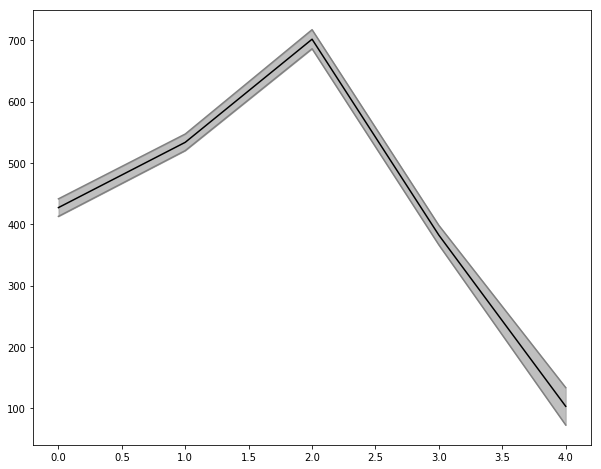

In [91]:
plt.figure(figsize=(10, 8))
plt.fill_between(range(5), grass_min.T, grass_max.T, alpha=0.5,color='gray')
plt.plot(grass_mean.T, c='k')
plt.plot(grass_min.T, c='gray')
plt.plot(grass_max.T, c='gray')